This notebook demonstrates how to extend the Assignment 2 workflow with a linked pair of R-trees: one for spatial lookup of platypus observations and a second one for temporal intervals. The implementation mirrors the design plan and keeps both indices connected through shared occurrence identifiers.

In [50]:
# --- Imports ---
import os
from datetime import datetime, timezone
from typing import Dict, List, Optional, Tuple

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


In [51]:
# --- Configuration ---
DATA_PATH = 'Dataset/Platypus/Platypus.csv'
TARGET_CRS = 'EPSG:3577'  # Australian Albers for metric distance

TIME_FIELDS = {
    'eventDate': 'eventDate',
    'eventTime': 'eventTime',
    'startDayOfYear': 'startDayOfYear',
    'endDayOfYear': 'endDayOfYear',
    'year': 'year',
    'month': 'month',
    'day': 'day'
}

In [52]:
# --- Data Loading and Cleaning ---


def read_platypus_dataset(path: str) -> pd.DataFrame:
    required_columns = [
        'occurrenceID', 'decimalLatitude', 'decimalLongitude',
        'eventDate', 'eventTime', 'startDayOfYear', 'endDayOfYear',
        'year', 'month', 'day', 'coordinateUncertaintyInMeters', 'eventRemarks'
    ]
    df = pd.read_csv(path, usecols=lambda c: c in required_columns, low_memory=False)
    initial_rows = len(df)
    df['occurrenceID'] = df['occurrenceID'].astype(str).str.strip()
    df = df[df['occurrenceID'] != '']
    df = df.drop_duplicates(subset='occurrenceID')
    df['decimalLatitude'] = pd.to_numeric(df['decimalLatitude'], errors='coerce')
    df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'], errors='coerce')
    df = df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    df = df[df['decimalLatitude'].between(-90.0, 90.0) & df['decimalLongitude'].between(-180.0, 180.0)]
    has_event = df[['eventDate', 'year', 'month', 'day']].notna().any(axis=1)
    df = df[has_event]
    filtered_rows = len(df)
    print(f"Filtered platypus records from {initial_rows} to {filtered_rows} entries with valid IDs, coordinates, and event data.")
    return df


def parse_event_timestamp(row: pd.Series) -> Tuple[Optional[datetime], Optional[datetime]]:
    if pd.notna(row.get('eventDate')):
        try:
            base_date = pd.to_datetime(row['eventDate'], utc=True)
        except Exception:
            base_date = None
    else:
        parts = [row.get('year'), row.get('month'), row.get('day')]
        if all(pd.notna(p) for p in parts):
            try:
                base_date = datetime(int(row['year']), int(row['month']), int(row['day']), tzinfo=timezone.utc)
            except Exception:
                base_date = None
        else:
            base_date = None


    if base_date is None:
        return None, None


    if pd.notna(row.get('eventTime')):
        try:
            time_component = pd.to_datetime(str(row['eventTime'])).time()
            start_dt = datetime.combine(base_date.date(), time_component, tzinfo=timezone.utc)
        except Exception:
            start_dt = base_date
    else:
        start_dt = base_date


    if pd.notna(row.get('startDayOfYear')) and pd.notna(row.get('endDayOfYear')):
        try:
            doy_span = int(row['endDayOfYear']) - int(row['startDayOfYear'])
            end_dt = start_dt + pd.to_timedelta(max(doy_span, 0), unit='D')
        except Exception:
            end_dt = start_dt
    else:
        end_dt = start_dt
    return start_dt, end_dt


def build_spatiotemporal_dataframe(df: pd.DataFrame) -> gpd.GeoDataFrame:
    starts: List[Optional[datetime]] = []
    ends: List[Optional[datetime]] = []
    for _, row in df.iterrows():
        start_dt, end_dt = parse_event_timestamp(row)
        starts.append(start_dt)
        ends.append(end_dt)
    df = df.assign(start_time=starts, end_time=ends)
    df = df.dropna(subset=['start_time'])
    df.loc[df['end_time'].isna(), 'end_time'] = df['start_time']
    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])],
        crs='EPSG:4326'
    )
    gdf = gdf.to_crs(TARGET_CRS)
    gdf['start_epoch'] = gdf['start_time'].apply(lambda dt: dt.timestamp())
    gdf['end_epoch'] = gdf['end_time'].apply(lambda dt: dt.timestamp())
    return gdf

In [53]:
# --- Load and Prepare Dataset ---
if os.path.exists(DATA_PATH):
    raw_df = read_platypus_dataset(DATA_PATH)
    platypus_gdf = build_spatiotemporal_dataframe(raw_df)
    print(f'Loaded {len(platypus_gdf)} platypus observations with spatiotemporal attributes.')
else:
    platypus_gdf = gpd.GeoDataFrame()
    print('Dataset not found. Please ensure the CSV file is available.')

Filtered platypus records from 30334 to 16974 entries with valid IDs, coordinates, and event data.
Loaded 15895 platypus observations with spatiotemporal attributes.
Loaded 15895 platypus observations with spatiotemporal attributes.


In [54]:
# --- Shared R-Tree Data Structures ---
class RTreeNode:
    def __init__(self, is_leaf: bool = True, capacity: int = 8):
        self.is_leaf = is_leaf
        self.capacity = capacity
        self.children: List[Tuple[Tuple[float, float, float, float], object]] = []
        self.bbox: Optional[Tuple[float, float, float, float]] = None

    def update_bbox(self) -> None:
        if not self.children:
            self.bbox = None
            return
        xs_min, ys_min, xs_max, ys_max = zip(*[c[0] for c in self.children])
        self.bbox = (min(xs_min), min(ys_min), max(xs_max), max(ys_max))

    def insert(self, bbox: Tuple[float, float, float, float], payload: object):
        if self.is_leaf:
            self.children.append((bbox, payload))
            self.update_bbox()
            if len(self.children) > self.capacity:
                return self.split()
            return None
        index = self._choose_subtree(bbox)
        child_bbox, child_node = self.children[index]
        split_result = child_node.insert(bbox, payload)
        if split_result:
            self.children.append(split_result)
        # Refresh child bounding box
        self.children[index] = (child_node.bbox, child_node)
        self.update_bbox()
        if len(self.children) > self.capacity:
            return self.split()
        return None

    def query(self, bbox: Tuple[float, float, float, float], results: Optional[List[object]] = None):
        if results is None:
            results = []
        if not self.bbox or not self._intersects(self.bbox, bbox):
            return results
        if self.is_leaf:
            for child_bbox, payload in self.children:
                if self._intersects(child_bbox, bbox):
                    results.append((child_bbox, payload))
        else:
            for child_bbox, child_node in self.children:
                if self._intersects(child_bbox, bbox):
                    child_node.query(bbox, results)
        return results

    def split(self):
        self.children.sort(key=lambda item: item[0][0])
        mid = len(self.children) // 2
        sibling = RTreeNode(is_leaf=self.is_leaf, capacity=self.capacity)
        sibling.children = self.children[mid:]
        self.children = self.children[:mid]
        self.update_bbox()
        sibling.update_bbox()
        return sibling.bbox, sibling

    def _choose_subtree(self, bbox: Tuple[float, float, float, float]) -> int:
        best_index = 0
        min_enlargement = float('inf')
        for idx, (child_bbox, _) in enumerate(self.children):
            enlargement = self._required_enlargement(child_bbox, bbox)
            if enlargement < min_enlargement:
                min_enlargement = enlargement
                best_index = idx
        return best_index

    def _required_enlargement(self, current: Tuple[float, float, float, float], new: Tuple[float, float, float, float]) -> float:
        union = (
            min(current[0], new[0]),
            min(current[1], new[1]),
            max(current[2], new[2]),
            max(current[3], new[3])
        )
        return self._area(union) - self._area(current)

    @staticmethod
    def _area(bbox: Tuple[float, float, float, float]) -> float:
        return max(bbox[2] - bbox[0], 0.0) * max(bbox[3] - bbox[1], 0.0)

    @staticmethod
    def _intersects(a: Tuple[float, float, float, float], b: Tuple[float, float, float, float]) -> bool:
        return not (a[2] < b[0] or a[0] > b[2] or a[3] < b[1] or a[1] > b[3])

class RTree:
    def __init__(self, capacity: int = 8):
        self.capacity = capacity
        self.root = RTreeNode(is_leaf=True, capacity=capacity)

    def insert(self, bbox: Tuple[float, float, float, float], payload: object) -> None:
        split_result = self.root.insert(bbox, payload)
        if split_result:
            new_root = RTreeNode(is_leaf=False, capacity=self.capacity)
            new_root.children = [(self.root.bbox, self.root), split_result]
            new_root.update_bbox()
            self.root = new_root

    def query(self, bbox: Tuple[float, float, float, float]):
        return self.root.query(bbox)

In [55]:
# --- R*-Tree Implementation ---
import math

class RStarTreeNode:
    def __init__(self, is_leaf: bool = True, capacity: int = 8, parent: Optional['RStarTreeNode'] = None):
        self.is_leaf = is_leaf
        self.capacity = capacity
        self.children: List[Tuple[Tuple[float, float, float, float], object]] = []
        self.bbox: Optional[Tuple[float, float, float, float]] = None
        self.parent = parent

    def update_bbox(self) -> None:
        if not self.children:
            self.bbox = None
            return
        xs_min, ys_min, xs_max, ys_max = zip(*[child[0] for child in self.children])
        self.bbox = (min(xs_min), min(ys_min), max(xs_max), max(ys_max))

    @staticmethod
    def _area(bbox: Tuple[float, float, float, float]) -> float:
        return max(bbox[2] - bbox[0], 0.0) * max(bbox[3] - bbox[1], 0.0)

    @staticmethod
    def _perimeter(bbox: Tuple[float, float, float, float]) -> float:
        return 2.0 * (max(bbox[2] - bbox[0], 0.0) + max(bbox[3] - bbox[1], 0.0))

    @staticmethod
    def _union(b1: Tuple[float, float, float, float], b2: Tuple[float, float, float, float]) -> Tuple[float, float, float, float]:
        return (min(b1[0], b2[0]), min(b1[1], b2[1]), max(b1[2], b2[2]), max(b1[3], b2[3]))

    @staticmethod
    def _intersects(a: Tuple[float, float, float, float], b: Tuple[float, float, float, float]) -> bool:
        return not (a[2] < b[0] or a[0] > b[2] or a[3] < b[1] or a[1] > b[3])

    def insert(self, bbox: Tuple[float, float, float, float], payload: object, level: int, reinsertion_levels: set):
        if self.is_leaf and level == 0:
            self.children.append((bbox, payload))
            self.update_bbox()
            if len(self.children) > self.capacity:
                self._handle_overflow(level, reinsertion_levels)
            return

        if self.is_leaf:
            # Should not happen: leaf but higher level requested
            self.children.append((bbox, payload))
            self.update_bbox()
            if len(self.children) > self.capacity:
                self._handle_overflow(level, reinsertion_levels)
            return

        child_index = self._choose_subtree(bbox)
        child_bbox, child_node = self.children[child_index]
        child_node.insert(bbox, payload, level - 1, reinsertion_levels)
        # Child may have been moved during reinsertion; update only if still present
        for idx, (existing_bbox, existing_node) in enumerate(self.children):
            if existing_node is child_node:
                self.children[idx] = (child_node.bbox, child_node)
                break
        self.update_bbox()
        if len(self.children) > self.capacity:
            self._handle_overflow(level, reinsertion_levels)

    def _choose_subtree(self, bbox: Tuple[float, float, float, float]) -> int:
        best_index = 0
        min_increase = math.inf
        min_area = math.inf
        for idx, (child_bbox, child_node) in enumerate(self.children):
            union_bbox = self._union(child_bbox, bbox)
            area_increase = self._area(union_bbox) - self._area(child_bbox)
            if math.isclose(area_increase, min_increase, rel_tol=1e-9):
                child_area = self._area(child_bbox)
                if child_area < min_area:
                    min_area = child_area
                    best_index = idx
            elif area_increase < min_increase:
                min_increase = area_increase
                min_area = self._area(child_bbox)
                best_index = idx
        return best_index

    def _handle_overflow(self, level: int, reinsertion_levels: set):
        if level > 0 and level not in reinsertion_levels:
            reinsertion_levels.add(level)
            self._reinsert()
        else:
            self._split()

    def _reinsert(self):
        if not self.children:
            return
        entries = self.children
        if not self.bbox:
            self.update_bbox()
        center_x = (self.bbox[0] + self.bbox[2]) / 2
        center_y = (self.bbox[1] + self.bbox[3]) / 2

        def distance_to_center(entry):
            bbox = entry[0]
            entry_cx = (bbox[0] + bbox[2]) / 2
            entry_cy = (bbox[1] + bbox[3]) / 2
            return (entry_cx - center_x) ** 2 + (entry_cy - center_y) ** 2

        entries.sort(key=distance_to_center, reverse=True)
        p = max(1, int(0.3 * len(entries)))
        to_reinsert = entries[:p]
        self.children = entries[p:]
        self.update_bbox()

        for entry in to_reinsert:
            payload = entry[1]
            bbox = entry[0]
            root = self._find_root()
            root._insert_entry_from_root(bbox, payload)

    def _split(self):
        self.children.sort(key=lambda entry: entry[0][0])
        mid = len(self.children) // 2
        new_node = RStarTreeNode(is_leaf=self.is_leaf, capacity=self.capacity, parent=self.parent)
        new_node.children = self.children[mid:]
        self.children = self.children[:mid]
        self.update_bbox()
        new_node.update_bbox()

        if self.parent is None:
            new_root = RStarTreeNode(is_leaf=False, capacity=self.capacity)
            self.parent = new_root
            new_node.parent = new_root
            new_root.children = [(self.bbox, self), (new_node.bbox, new_node)]
            new_root.update_bbox()
        else:
            self.parent.children.append((new_node.bbox, new_node))
            new_node.parent = self.parent
            self.parent.update_bbox()
            if len(self.parent.children) > self.parent.capacity:
                self.parent._handle_overflow(-1, set())

    def _find_root(self) -> 'RStarTreeNode':
        node = self
        while node.parent is not None:
            node = node.parent
        return node

    def _insert_entry_from_root(self, bbox: Tuple[float, float, float, float], payload: object):
        if self.is_leaf:
            self.children.append((bbox, payload))
            self.update_bbox()
            if len(self.children) > self.capacity:
                self._handle_overflow(0, set())
            return
        child_index = self._choose_subtree(bbox)
        child_bbox, child_node = self.children[child_index]
        child_node._insert_entry_from_root(bbox, payload)
        for idx, (existing_bbox, existing_node) in enumerate(self.children):
            if existing_node is child_node:
                self.children[idx] = (child_node.bbox, child_node)
                break
        self.update_bbox()

    def query(self, bbox: Tuple[float, float, float, float], results: Optional[List[Tuple[Tuple[float, float, float, float], object]]] = None):
        if results is None:
            results = []
        if not self.bbox or not self._intersects(self.bbox, bbox):
            return results
        if self.is_leaf:
            for child_bbox, payload in self.children:
                if self._intersects(child_bbox, bbox):
                    results.append((child_bbox, payload))
        else:
            for child_bbox, child_node in self.children:
                if self._intersects(child_bbox, bbox):
                    child_node.query(bbox, results)
        return results

class RStarTree:
    def __init__(self, capacity: int = 8):
        self.capacity = capacity
        self.root = RStarTreeNode(is_leaf=True, capacity=capacity)

    def insert(self, bbox: Tuple[float, float, float, float], payload: object):
        reinsertion_levels: set = set()
        self.root.insert(bbox, payload, level=0, reinsertion_levels=reinsertion_levels)
        if self.root.parent is not None:
            self.root = self.root.parent

    def query(self, bbox: Tuple[float, float, float, float]):
        return self.root.query(bbox)

In [56]:
# --- Index Builders ---
def build_spatial_rtree(gdf: gpd.GeoDataFrame, capacity: int = 16) -> RTree:
    tree = RTree(capacity=capacity)
    for row in gdf.itertuples():
        geom = row.geometry
        minx, miny, maxx, maxy = geom.bounds
        tree.insert((minx, miny, maxx, maxy), row.occurrenceID)
    return tree

def build_temporal_rtree(gdf: gpd.GeoDataFrame, capacity: int = 16) -> RTree:
    tree = RTree(capacity=capacity)
    for row in gdf.itertuples():
        start_epoch = float(row.start_epoch)
        end_epoch = float(row.end_epoch)
        bbox = (start_epoch, 0.0, end_epoch, 1.0)
        tree.insert(bbox, row.occurrenceID)
    return tree

def build_spatial_rstar_tree(gdf: gpd.GeoDataFrame, capacity: int = 16) -> RStarTree:
    tree = RStarTree(capacity=capacity)
    for row in gdf.itertuples():
        geom = row.geometry
        minx, miny, maxx, maxy = geom.bounds
        tree.insert((minx, miny, maxx, maxy), row.occurrenceID)
    return tree

def build_temporal_rstar_tree(gdf: gpd.GeoDataFrame, capacity: int = 16) -> RStarTree:
    tree = RStarTree(capacity=capacity)
    for row in gdf.itertuples():
        start_epoch = float(row.start_epoch)
        end_epoch = float(row.end_epoch)
        bbox = (start_epoch, 0.0, end_epoch, 1.0)
        tree.insert(bbox, row.occurrenceID)
    return tree

def link_indices(gdf: gpd.GeoDataFrame) -> Dict[str, Dict[str, object]]:
    return {
        row.occurrenceID: {
            'start_epoch': float(row.start_epoch),
            'end_epoch': float(row.end_epoch),
            'geometry': row.geometry
        }
        for row in gdf.itertuples()
    }

In [57]:
# --- Build Spatiotemporal Indices ---
if not platypus_gdf.empty:
    spatial_index = build_spatial_rtree(platypus_gdf)
    temporal_index = build_temporal_rtree(platypus_gdf)
    shared_payload = link_indices(platypus_gdf)
    print(f'Spatial index size: {len(shared_payload)} entries')
else:
    spatial_index = RTree()
    temporal_index = RTree()
    shared_payload = {}
    print('Indices created but dataset is empty.')

Spatial index size: 15895 entries


In [58]:
# --- Query Utilities ---
def query_spatiotemporal(region_geom, start_dt: datetime, end_dt: datetime) -> gpd.GeoDataFrame:
    if not shared_payload:
        return gpd.GeoDataFrame()
    
    minx, miny, maxx, maxy = region_geom.bounds
    spatial_candidates = spatial_index.query((minx, miny, maxx, maxy))
    if not spatial_candidates:
        return gpd.GeoDataFrame()
    
    start_epoch = start_dt.timestamp()
    end_epoch = end_dt.timestamp()
    temporal_candidates = temporal_index.query((start_epoch, 0.0, end_epoch, 1.0))
    spatial_ids = {payload for _, payload in spatial_candidates}
    temporal_ids = {payload for _, payload in temporal_candidates}
    matched_ids = spatial_ids & temporal_ids
    if not matched_ids:
        return gpd.GeoDataFrame()
    
    rows = []
    for occurrence_id in matched_ids:
        payload = shared_payload.get(occurrence_id)
        if not payload:
            continue
        rows.append({
            'occurrenceID': occurrence_id,
            'start_time': datetime.fromtimestamp(payload['start_epoch'], tz=timezone.utc),
            'end_time': datetime.fromtimestamp(payload['end_epoch'], tz=timezone.utc),
            'geometry': payload['geometry']
        })
    
    if not rows:
        return gpd.GeoDataFrame()
    
    result_gdf = gpd.GeoDataFrame(
        rows,
        geometry='geometry',
        crs=platypus_gdf.crs if not platypus_gdf.empty else TARGET_CRS
    )
    return result_gdf

def nearest_in_time(point_geom, target_dt: datetime, radius: float = 5000.0) -> Optional[Tuple[str, float, float]]:
    if not shared_payload:
        return None
    
    px, py = point_geom.x, point_geom.y
    target_epoch = target_dt.timestamp()
    current_radius = radius
    max_radius = radius * 16
    best_match: Optional[Tuple[str, float, float]] = None
    best_temporal_gap = float('inf')
    
    while current_radius <= max_radius:
        bbox = (px - current_radius, py - current_radius, px + current_radius, py + current_radius)
        spatial_candidates = spatial_index.query(bbox)
        if not spatial_candidates:
            current_radius *= 2
            continue
        
        for _, occurrence_id in spatial_candidates:
            payload = shared_payload.get(occurrence_id)
            if not payload:
                continue
            spatial_distance = point_geom.distance(payload['geometry'])
            if spatial_distance > current_radius:
                continue
            start_epoch = payload['start_epoch']
            end_epoch = payload['end_epoch']
            if start_epoch <= target_epoch <= end_epoch:
                temporal_gap = 0.0
            else:
                temporal_gap = min(abs(start_epoch - target_epoch), abs(end_epoch - target_epoch))
            if temporal_gap < best_temporal_gap:
                best_temporal_gap = temporal_gap
                best_match = (occurrence_id, temporal_gap, spatial_distance)
        
        if best_match:
            break
        current_radius *= 2
    
    return best_match

,Index,Metric,Value
0,R-Tree,Spatial Build Time (s),0.367990
1,R-Tree,Spatial Memory (MB),5.698445
2,R-Tree,Temporal Build Time (s),0.362460
3,R-Tree,Temporal Memory (MB),4.999570
4,R-Tree,Linked Query Time (s),0.003883
5,R-Tree,Linked Query Matches,12.000000
6,R*-Tree,Spatial Build Time (s),0.444868
7,R*-Tree,Spatial Memory (MB),5.782375
8,R*-Tree,Temporal Build Time (s),0.339404
9,R*-Tree,Temporal Memory (MB),5.066509


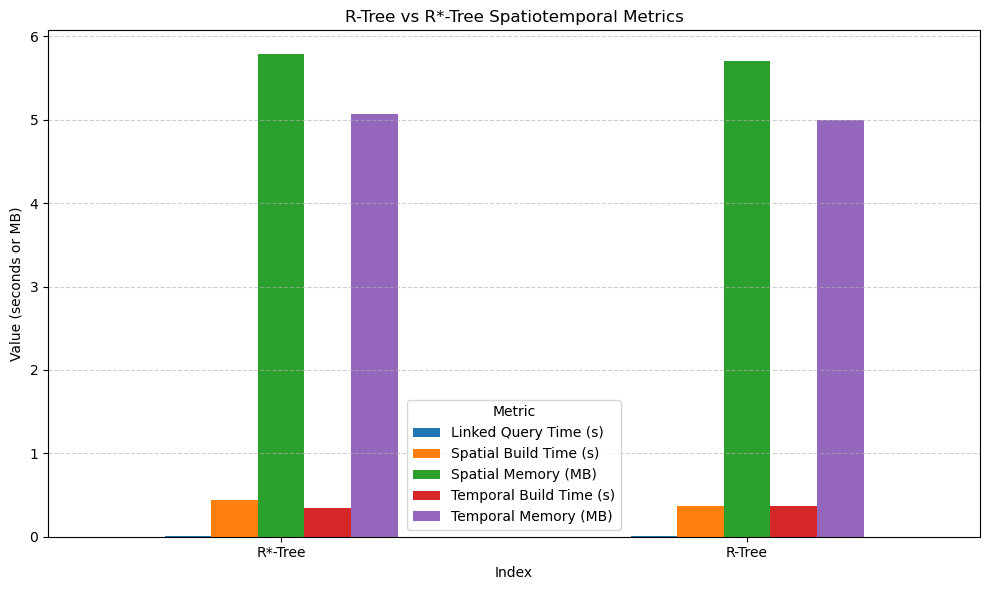

In [59]:
# --- Spatiotemporal Performance Benchmark ---
import sys
import time
import matplotlib.pyplot as plt
from IPython.display import display

def get_deep_size(obj, seen=None):
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum(get_deep_size(v, seen) for v in obj.values())
        size += sum(get_deep_size(k, seen) for k in obj.keys())
    elif hasattr(obj, '__dict__'):
        size += get_deep_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum(get_deep_size(i, seen) for i in obj)
    return size

def run_linked_query(spatial_idx, temporal_idx, payload, region_geom, start_dt, end_dt) -> gpd.GeoDataFrame:
    if not payload:
        return gpd.GeoDataFrame()
    minx, miny, maxx, maxy = region_geom.bounds
    spatial_candidates = spatial_idx.query((minx, miny, maxx, maxy))
    if not spatial_candidates:
        return gpd.GeoDataFrame()
    start_epoch = start_dt.timestamp()
    end_epoch = end_dt.timestamp()
    temporal_candidates = temporal_idx.query((start_epoch, 0.0, end_epoch, 1.0))
    spatial_ids = {entry[1] for entry in spatial_candidates}
    temporal_ids = {entry[1] for entry in temporal_candidates}
    matched_ids = spatial_ids & temporal_ids
    if not matched_ids:
        return gpd.GeoDataFrame()
    rows = []
    for occurrence_id in matched_ids:
        record = payload.get(occurrence_id)
        if not record:
            continue
        rows.append({
            'occurrenceID': occurrence_id,
            'start_time': datetime.fromtimestamp(record['start_epoch'], tz=timezone.utc),
            'end_time': datetime.fromtimestamp(record['end_epoch'], tz=timezone.utc),
            'geometry': record['geometry']
        })
    if not rows:
        return gpd.GeoDataFrame()
    return gpd.GeoDataFrame(rows, geometry='geometry', crs=platypus_gdf.crs if not platypus_gdf.empty else TARGET_CRS)

def measure_index(label: str, spatial_builder, temporal_builder):
    t0 = time.perf_counter()
    spatial_idx = spatial_builder(platypus_gdf)
    spatial_build_time = time.perf_counter() - t0
    spatial_mem_mb = get_deep_size(spatial_idx) / (1024 ** 2)

    t0 = time.perf_counter()
    temporal_idx = temporal_builder(platypus_gdf)
    temporal_build_time = time.perf_counter() - t0
    temporal_mem_mb = get_deep_size(temporal_idx) / (1024 ** 2)

    payload = link_indices(platypus_gdf)
    sample_geom = platypus_gdf.geometry.iloc[0]
    region_buffer = sample_geom.buffer(1000)
    window_start = platypus_gdf['start_time'].min()
    window_end = platypus_gdf['end_time'].max()

    t0 = time.perf_counter()
    query_results = run_linked_query(spatial_idx, temporal_idx, payload, region_buffer, window_start, window_end)
    linked_query_time = time.perf_counter() - t0
    linked_matches = len(query_results)

    return [
        {'Index': label, 'Metric': 'Spatial Build Time (s)', 'Value': spatial_build_time},
        {'Index': label, 'Metric': 'Spatial Memory (MB)', 'Value': spatial_mem_mb},
        {'Index': label, 'Metric': 'Temporal Build Time (s)', 'Value': temporal_build_time},
        {'Index': label, 'Metric': 'Temporal Memory (MB)', 'Value': temporal_mem_mb},
        {'Index': label, 'Metric': 'Linked Query Time (s)', 'Value': linked_query_time},
        {'Index': label, 'Metric': 'Linked Query Matches', 'Value': linked_matches}
    ]

if platypus_gdf.empty:
    print('Benchmark skipped: platypus dataset not loaded.')
else:
    comparison_plan = [
        ('R-Tree', build_spatial_rtree, build_temporal_rtree),
        ('R*-Tree', build_spatial_rstar_tree, build_temporal_rstar_tree)
    ]

    all_results: List[Dict[str, object]] = []
    for label, spatial_builder, temporal_builder in comparison_plan:
        all_results.extend(measure_index(label, spatial_builder, temporal_builder))

    df_results = pd.DataFrame(all_results)
    display(df_results)

    plot_df = df_results[df_results['Metric'].isin([
        'Spatial Build Time (s)', 'Spatial Memory (MB)',
        'Temporal Build Time (s)', 'Temporal Memory (MB)',
        'Linked Query Time (s)'
    ])]

    if not plot_df.empty:
        chart_data = plot_df.pivot(index='Index', columns='Metric', values='Value')
        ax = chart_data.plot(kind='bar', figsize=(10, 6), rot=0)
        ax.set_title('R-Tree vs R*-Tree Spatiotemporal Metrics')
        ax.set_ylabel('Value (seconds or MB)')
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

In [60]:
# --- Example Usage (Requires dataset) ---
if not platypus_gdf.empty:
    sample_point = platypus_gdf.geometry.iloc[0]
    region_buffer = sample_point.buffer(1000)  # 1 km buffer
    window_start = platypus_gdf['start_time'].min()
    window_end = platypus_gdf['end_time'].max()
    spatiotemporal_results = query_spatiotemporal(region_buffer, window_start, window_end)
    print(f'Spatiotemporal query returned {len(spatiotemporal_results)} observations.')
    nearest_match = nearest_in_time(sample_point, window_start)
    if nearest_match:
        print('Nearest match in time:', nearest_match)
else:
    print('Dataset unavailable: skipping example usage.')

Spatiotemporal query returned 12 observations.
Nearest match in time: ('3970405', 5589561600.0, 2700.4465643711596)
